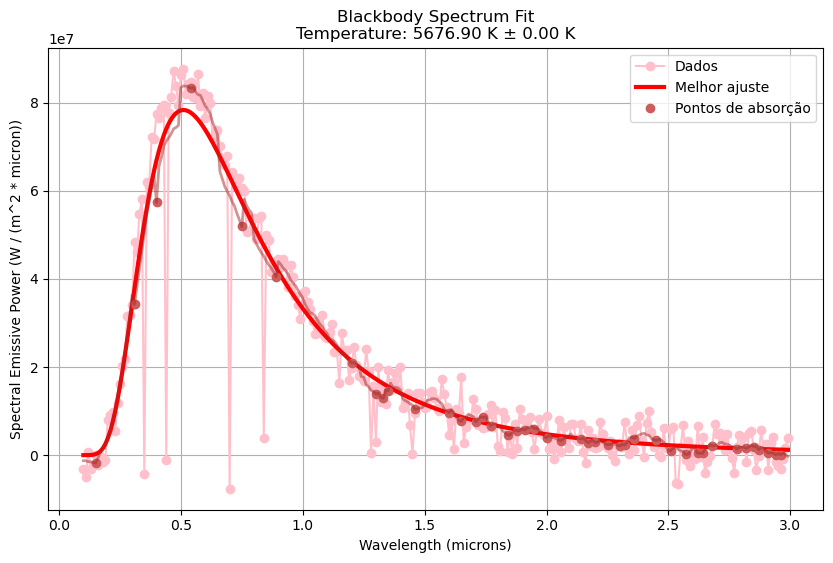

Best-Fit Temperature: 5676.90 K ± 0.00 K
Incerteza da Temperatura: ± 0.0048 K
Best-Fit Scaling Factor: 3.24e-06
Wavelengths of Absorption Bands (microns): 42
0.15 microns
0.31 microns
0.40 microns
0.54 microns
0.75 microns
0.89 microns
1.20 microns
1.30 microns
1.33 microns
1.35 microns
1.46 microns
1.60 microns
1.65 microns
1.71 microns
1.74 microns
1.77 microns
1.84 microns
1.88 microns
1.91 microns
1.95 microns
2.00 microns
2.06 microns
2.14 microns
2.17 microns
2.20 microns
2.25 microns
2.30 microns
2.32 microns
2.36 microns
2.45 microns
2.51 microns
2.57 microns
2.62 microns
2.64 microns
2.68 microns
2.78 microns
2.82 microns
2.85 microns
2.87 microns
2.91 microns
2.94 microns
2.96 microns


In [11]:
#Importa as dependências necessárias
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.constants as const

#Carrega os dados a partir de um arquivo de texto, no nosso caso, 'corpo_negro.txt'
data = np.loadtxt('corpo_negro.txt')

#Extrai os dados de comprimento de onda e potência emissiva espectral
wavelength = data[:, 0]
emissive_power = data[:, 1]

#Define a função que calcula a intensidade espectral com base na Lei de Planck. As constantes já são calculadas pelo
#scipy.constants
def planck_lambda(lam, T, A):
    lam = lam * 1e-6 # Converte o comprimento de onda de micrômetros para metros
    E = A * (2 * const.h * const.c**2 / lam**5) / (np.exp(const.h * const.c / (lam * const.k * T)) - 1)
    return E

#Define a função que calcula o qui-quadrado
def chi_squared(observed, expected, uncertainties):
    return np.sum(((observed - expected) / uncertainties) ** 2)

num_samples = 1000 #Numero de amostras para o metodo de Monte Carlo
temperature_samples = np.zeros(num_samples)
scaling_factor_samples = np.zeros(num_samples)

#Define o palpite inicial e incertezas dos parâmetros. Este passo às vezes é necessário para ajustes mais complexos
initial_guess = [3000, 1e-12]
param_uncertainties = [100, 1e-13]

#Suaviza os dados de potência emissiva utilizando uma convolução
smoothed_power = np.convolve(emissive_power, np.ones(10) / 10, mode='same')

#Identifica os índices dos mínimos locais no espectro suavizado
minima_indices = (smoothed_power[1:-1] < smoothed_power[:-2]) & (smoothed_power[1:-1] < smoothed_power[2:])

#Cria uma máscara booleana "mask" para excluir os pontos de absorção achados. Mais tarde iremos usá-lo para
#vê-los no plot, afim de identificar os pontos
mask = np.ones(len(wavelength), dtype=bool)
mask[1:-1] = ~minima_indices


#Ajuste de Monte Carlo
for i in range(num_samples):
#Gera parâmetros perturbados com base nas incertezas
    perturbed_params = np.random.normal(initial_guess, param_uncertainties)
#Cria arrays de comprimento de onda e potência emissiva modificados usando a máscara. Ou seja, sem pontos de absorção
    modified_wavelength = wavelength[mask]
    modified_emissive_power = emissive_power[mask]
#Realiza o ajuste dos dados perturbados à função de Planck
    params, _ = curve_fit(planck_lambda, modified_wavelength, modified_emissive_power, p0=perturbed_params)
    temperature_samples[i], scaling_factor_samples[i] = params

#Calcula os valores do qui-quadrado para cada amostra
chi_squared_values = np.zeros(num_samples)
for i in range(num_samples):
    expected_emissive_power = planck_lambda(wavelength[mask], temperature_samples[i], scaling_factor_samples[i])
    chi_squared_values[i] = chi_squared(emissive_power[mask], expected_emissive_power, np.ones_like(emissive_power[mask]))

#Encontra os parâmetros de melhor ajuste com o argumento minimo, o menor valor do qui-quadrado
best_fit_index = np.argmin(chi_squared_values)
best_temperature = temperature_samples[best_fit_index]
best_scaling_factor = scaling_factor_samples[best_fit_index]

#Calcuando os desvios padrão das temperaturas
temperature_uncertainty = np.std(temperature_samples)

#Identifica os comprimentos de onda das bandas de absorção
absorption_band_wavelengths = wavelength[~mask]

best_fit_emissive_power = planck_lambda(wavelength, best_temperature, best_scaling_factor)

plt.figure(figsize=(10, 6))
plt.plot(wavelength, emissive_power, label='Dados', marker='o', color='pink')
plt.plot(wavelength, best_fit_emissive_power, label='Melhor ajuste', color='red',linewidth=3)
plt.plot(wavelength[~mask],smoothed_power[~mask], label='Pontos de absorção', color='indianred', marker='o', linestyle='none')
plt.plot(wavelength,smoothed_power,linewidth=2, alpha=0.5, color='brown')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Spectral Emissive Power (W / (m^2 * micron))')
plt.title(f'Blackbody Spectrum Fit\nTemperature: {best_temperature:.2f} K ± {temperature_uncertainty:.2f} K')
plt.legend()
plt.grid(True)

plt.show()

print(f'Best-Fit Temperature: {best_temperature:.2f} K ± {temperature_uncertainty:.2f} K')
print(f'Incerteza da Temperatura: ± {temperature_uncertainty:.4f} K')
print(f'Best-Fit Scaling Factor: {best_scaling_factor:.2e}')
print("Wavelengths of Absorption Bands (microns):",len(absorption_band_wavelengths))
for wavelength in absorption_band_wavelengths:
    print(f"{wavelength:.2f} microns")
    
